Lab 5-Image Alignment and Stitching


Part 1: Image Alignment với RANSAC


In [1]:
# Cell 1: Import thư viện cơ bản
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Hiển thị ảnh ngay trong Jupyter Notebook
%matplotlib inline

print("OpenCV version:", cv2.__version__)


OpenCV version: 4.11.0


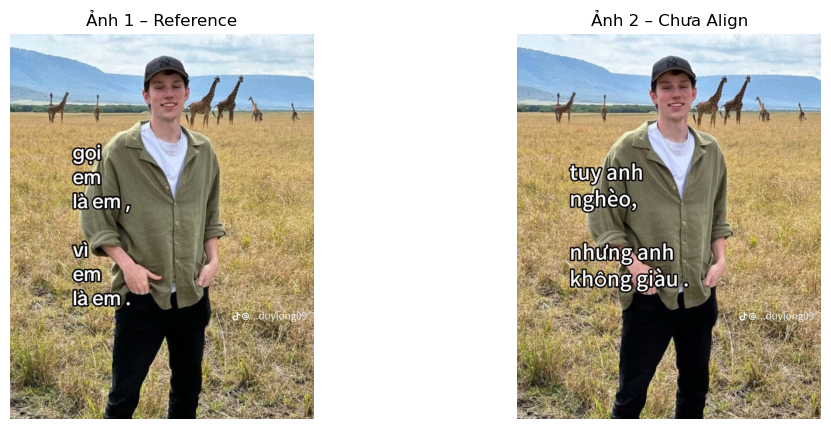

In [ ]:
# Cell 2: Đọc ảnh gốc (reference) và ảnh cần align
# Ảnh tham chiếu (reference)
path_img1 = r"E:\MSE\HomeWork\Ky 2\IVP501\Test\IMG\2f5b960d37378269db2610.jpg"
# Ảnh sẽ warp lên img1
path_img2 = r"E:\MSE\HomeWork\Ky 2\IVP501\Test\IMG\ee5edf077e3dcb63922c12.jpg"

# Đọc ảnh dưới dạng màu (BGR)
img1_color = cv2.imread(path_img1, cv2.IMREAD_COLOR)
img2_color = cv2.imread(path_img2, cv2.IMREAD_COLOR)

# Nếu không đọc được, báo lỗi ngay
if img1_color is None or img2_color is None:
    raise FileNotFoundError("Không đọc được ảnh. Kiểm tra lại đường dẫn!")

# Chuyển sang RGB để hiển thị với matplotlib (nếu không, ảnh sẽ bị xanh lam)
img1_rgb = cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_color, cv2.COLOR_BGR2RGB)

# Hiển thị song song hai ảnh
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Ảnh 1 – Reference")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Ảnh 2 – Chưa Align")
plt.axis("off")
plt.show()


In [ ]:
# Cell 3: Khởi tạo ORB, detect keypoints và compute descriptors
# Giới hạn tối đa 5000 điểm
orb = cv2.ORB_create(5000)

# Chuyển đổi ảnh sang grayscale cho ORB detect thuận lợi
gray1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

# Detect keypoints và compute descriptor
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

print(f"Ảnh 1: {len(kp1)} keypoints  |  Ảnh 2: {len(kp2)} keypoints")


Ảnh 1: 5000 keypoints  |  Ảnh 2: 5000 keypoints


In [ ]:

# Cell 4: Khởi tạo BFMatcher với tiêu chí Hamming (phù hợp với ORB)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Tạo danh sách matches giữa des1 và des2
matches = bf.match(des1, des2)
print("Tổng số matches tìm được:", len(matches))

# Sắp xếp matches theo distance nhỏ → lớn (distance càng nhỏ càng “giống nhau”)
matches = sorted(matches, key=lambda x: x.distance)


Tổng số matches tìm được: 1446


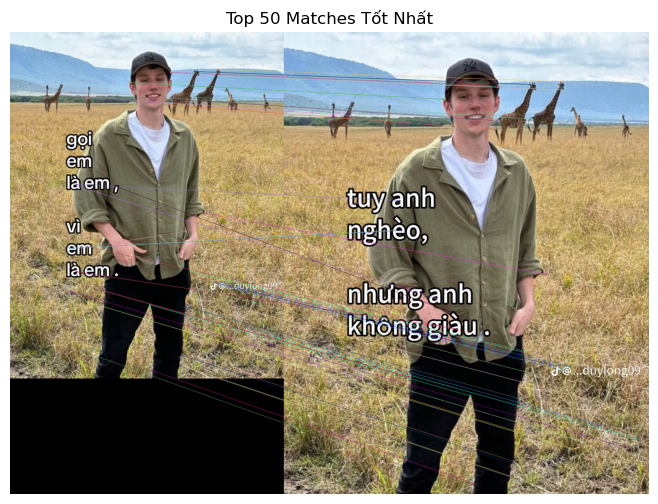

In [ ]:
# Cell 5: Lấy 50 matches tốt nhất để hiển thị
num_display = 50
best_matches = matches[:num_display]

# Vẽ matches
img_matches = cv2.drawMatches(
    img1_rgb, kp1,    # ảnh và keypoints của ảnh1 (đã convert sang RGB để show)
    img2_rgb, kp2,    # ảnh và keypoints của ảnh2
    best_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15, 6))
plt.imshow(img_matches)
plt.title(f"Top {num_display} Matches Tốt Nhất")
plt.axis("off")
plt.show()


In [ ]:
# Cell 6: Chọn ra một số matches tốt (ví dụ 200) để tính Homography
num_for_homography = 200
good_matches = matches[:num_for_homography]

# Chuẩn bị mảng điểm tương ứng:
#   - pts1: tọa độ keypoints trong ảnh1
#   - pts2: tọa độ keypoints trong ảnh2
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Tính Homography từ pts2 → pts1, dùng RANSAC để loại outliers
H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, ransacReprojThreshold=5.0)

if H is None:
    raise RuntimeError(
        "Không tìm được ma trận Homography. Thử tăng số matches hoặc giảm threshold!")

print("Ma trận Homography 3x3:\n", H)


Ma trận Homography 3x3:
 [[ 7.48991831e-01  5.91755400e-05  1.40545094e-01]
 [-4.45308425e-04  7.49516310e-01  3.83313723e-01]
 [-4.17101076e-07  1.15652265e-08  1.00000000e+00]]


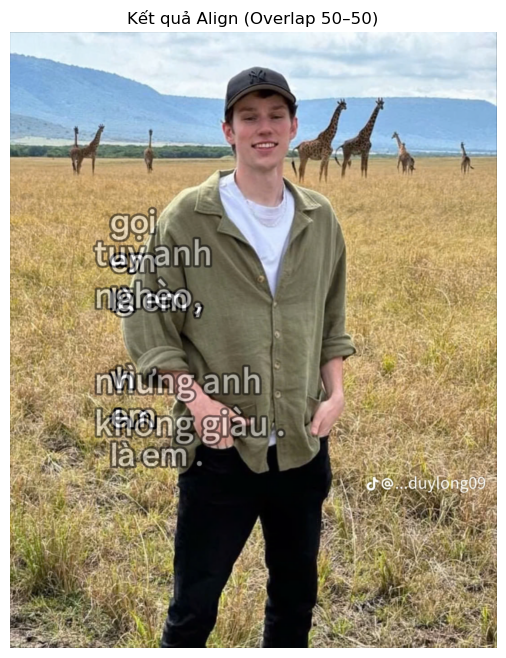

In [ ]:
# Cell 7: Warp ảnh2_color vào hệ tọa độ của ảnh1_color
h1, w1 = img1_color.shape[:2]
warped_img2 = cv2.warpPerspective(img2_color, H, (w1, h1))

# Để nhìn rõ overlap, ta chồng 50-50:
aligned_vis = cv2.addWeighted(img1_rgb, 0.5, cv2.cvtColor(
    warped_img2, cv2.COLOR_BGR2RGB), 0.5, 0)

plt.figure(figsize=(8, 8))
plt.imshow(aligned_vis)
plt.title("Kết quả Align (Overlap 50–50)")
plt.axis("off")
plt.show()


Part 2: Image Stitching (Ghép Nhiều Ảnh)


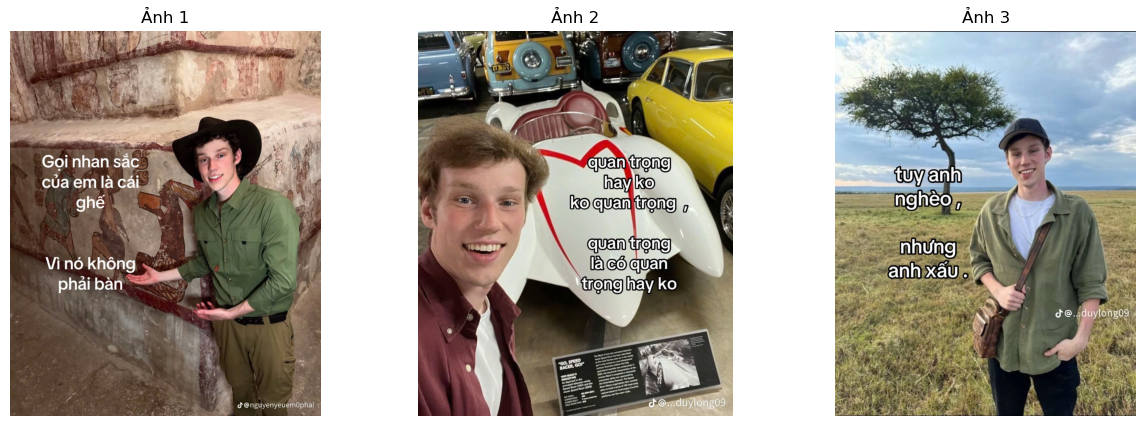

In [ ]:
# Cell 8: Đọc 3 ảnh cần stitch (ví dụ)
image_paths = [r"E:\MSE\HomeWork\Ky 2\IVP501\Test\IMG\2973e03f4105f45bad144.jpg", r"E:\MSE\HomeWork\Ky 2\IVP501\Test\IMG\a4bd8ba62a9c9fc2c68d9.jpg",
               r"E:\MSE\HomeWork\Ky 2\IVP501\Test\IMG\e657fe045f3eea60b32f11.jpg"]  # thay đổi tương ứng

images_color = []
for p in image_paths:
    img = cv2.imread(p, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Không đọc được ảnh {p}. Kiểm tra đường dẫn!")
    images_color.append(img)

# Chuyển từng ảnh sang RGB cho matplotlib
images_rgb = [cv2.cvtColor(im, cv2.COLOR_BGR2RGB) for im in images_color]

# Hiển thị sơ bộ
plt.figure(figsize=(15, 5))
for idx, img in enumerate(images_rgb):
    plt.subplot(1, len(images_rgb), idx+1)
    plt.imshow(img)
    plt.title(f"Ảnh {idx+1}")
    plt.axis("off")
plt.show()


In [ ]:
# Cell 9: Hàm compute_homography(imgA_color, imgB_color)
def compute_homography(imgA_color, imgB_color,
                       detector=cv2.ORB_create(3000),
                       matcher=cv2.BFMatcher(
                           cv2.NORM_HAMMING, crossCheck=True),
                       num_matches_keep=200):
    """
    Input:
      - imgA_color, imgB_color: ảnh màu (BGR), muốn tìm homography từ imgB → imgA
      - detector: ORB hoặc SIFT/AKAZE
      - matcher: BFMatcher hoặc FLANN
      - num_matches_keep: số match tốt nhất để tính H
    Output:
      - H: ma trận homography 3x3 (None nếu fail)
      - mask: inliers mask từ RANSAC (None nếu fail)
    """
    grayA = cv2.cvtColor(imgA_color, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imgB_color, cv2.COLOR_BGR2GRAY)

    # 1. Detect + compute descriptor
    kpA, desA = detector.detectAndCompute(grayA, None)
    kpB, desB = detector.detectAndCompute(grayB, None)
    if desA is None or desB is None or len(kpA) < 4 or len(kpB) < 4:
        return None, None

    # 2. Match descriptors
    matches = matcher.match(desA, desB)
    matches = sorted(matches, key=lambda x: x.distance)
    good = matches[:num_matches_keep]

    # 3. Chuẩn bị mảng điểm tương ứng
    ptsA = np.float32([kpA[m.queryIdx].pt for m in good]).reshape(-1, 2)
    ptsB = np.float32([kpB[m.trainIdx].pt for m in good]).reshape(-1, 2)

    # 4. Tính Homography với RANSAC
    H, mask = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 5.0)
    return H, mask


# Thử nghiệm: tính H giữa ảnh1 và ảnh2
H_test, mask_test = compute_homography(images_color[0], images_color[1])
print("H_test:\n", H_test)


H_test:
 [[-9.89360049e-02 -3.23292749e-01  3.68216095e+02]
 [-3.27010952e-01 -8.25803909e-01  1.00134361e+03]
 [-3.43304165e-04 -8.09470398e-04  1.00000000e+00]]


In [ ]:
# Cell 10: Tính homography cho tất cả ảnh so với ảnh1
num_images = len(images_color)
Hs = [None] * num_images
Hs[0] = np.eye(3, dtype=np.float64)  # Ảnh 1 làm center → biến đổi id

for i in range(1, num_images):
    Hs[i], _ = compute_homography(images_color[0], images_color[i])
    if Hs[i] is None:
        raise RuntimeError(f"Không tính được homography cho ảnh thứ {i+1}!")
    print(f"Homography của ảnh {i+1} → ảnh 1:\n", Hs[i])


Homography của ảnh 2 → ảnh 1:
 [[-9.89360049e-02 -3.23292749e-01  3.68216095e+02]
 [-3.27010952e-01 -8.25803909e-01  1.00134361e+03]
 [-3.43304165e-04 -8.09470398e-04  1.00000000e+00]]
Homography của ảnh 3 → ảnh 1:
 [[-6.64074488e+00 -5.40972276e+00  3.86914876e+03]
 [-2.41682576e+00 -1.98496366e+01  1.07731290e+04]
 [-1.02896416e-03 -7.70951150e-03  1.00000000e+00]]


In [ ]:
# Sau khi detect & match ORB, bạn có thể áp dụng ratio test (Lowe’s SIFT-style):
# (Mình ví dụ với FLANN để minh hoạ, nhưng ORB+BFMatcher cũng làm tương tự.)
import cv2

# Nếu bạn xài SIFT, descriptor là float32 → được phép dùng FLANN:
sift = cv2.SIFT_create(5000)
kpA, desA = sift.detectAndCompute(grayA, None)
kpB, desB = sift.detectAndCompute(grayB, None)

# FLANN params
FLANN_INDEX_KDTREE = 1
index_params = {"algorithm": FLANN_INDEX_KDTREE, "trees": 5}
search_params = {"checks": 50}

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desA, desB, k=2)

# Ratio test để lọc matches tốt hơn
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) < 4:
    raise RuntimeError("Quá ít matches sau ratio test!")

ptsA = np.float32([kpA[m.queryIdx].pt for m in good]).reshape(-1, 2)
ptsB = np.float32([kpB[m.trainIdx].pt for m in good]).reshape(-1, 2)
H, mask = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 3.0)


NameError: name 'grayA' is not defined

In [ ]:
# Cell 12: Tạo canvas và mask
shift_x = -xmin_i if xmin_i < 0 else 0
shift_y = -ymin_i if ymin_i < 0 else 0

canvas = np.zeros((height_canvas, width_canvas, 3), dtype=np.uint8)
canvas_mask = np.zeros((height_canvas, width_canvas), dtype=np.uint8)

# Cell 13: Warp & blend từng ảnh
for i, img_color in enumerate(images_color):
    h, w = img_color.shape[:2]

    # Ma trận dịch (offset) về canvas
    T = np.array([
        [1, 0, shift_x],
        [0, 1, shift_y],
        [0, 0, 1]
    ], dtype=np.float64)

    # Ma trận tổng = translate T * Homography Hs[i]
    H_total = T.dot(Hs[i])

    # Warp ảnh i vào canvas
    warped = cv2.warpPerspective(
        img_color, H_total, (width_canvas, height_canvas))

    # Tạo mask cho warped: vùng nào != 0
    gray_w = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    _, mask_w = cv2.threshold(gray_w, 1, 255, cv2.THRESH_BINARY)

    # Xác định vùng overlap và mới
    region_overlap = (canvas_mask > 0) & (mask_w > 0)
    region_only_new = (canvas_mask == 0) & (mask_w > 0)

    # 1) Copy pixel từ warped ở vùng mới
    canvas[region_only_new] = warped[region_only_new]

    # 2) Blend vùng overlap (dùng average 50–50)
    canvas[region_overlap] = (
        (canvas[region_overlap].astype(np.float32) +
         warped[region_overlap].astype(np.float32))
        / 2
    ).astype(np.uint8)

    # 3) Cập nhật mask: pixel nào đã được fill
    canvas_mask[mask_w > 0] = 255

# Hiển thị kết quả stitching (panorama)
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(canvas_rgb)
plt.title("Kết quả Stitching (Linear Blending)")
plt.axis("off")
plt.show()


MemoryError: Unable to allocate 18.5 GiB for an array with shape (2489352380,) and data type int64

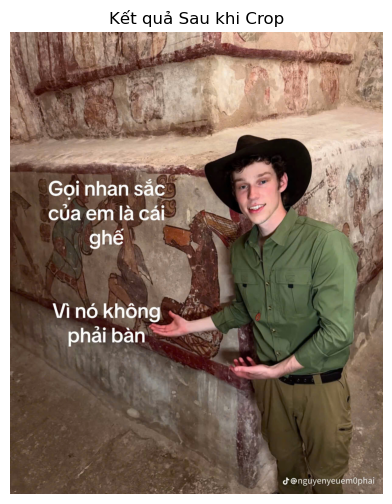

In [ ]:
# Cell 14: Crop vùng không phải nền đen
gray_canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray_canvas, 1, 255, cv2.THRESH_BINARY)

coords = np.column_stack(np.where(thresh > 0))  # lấy toạ độ pixel != 0
y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)

cropped = canvas[y_min:y_max+1, x_min:x_max+1]

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.title("Kết quả Sau khi Crop")
plt.axis("off")
plt.show()
